In [2]:
import numpy as np
np.random.seed(0)
import cv2
import matplotlib.pyplot as plt
import pandas as pd

import pickle
import matplotlib.image as mpimg
from scipy.misc import imread
from scipy.misc import imresize

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rc('figure', figsize=(10, 10))

In [3]:
gt = pickle.load(open('ground-truth.pkl', 'rb'))
gt['object-detection-crowdai/1479498371963069978.jpg']

array([[ 0.40885417,  0.44416667,  0.47135417,  0.53666667,  1.        ,
         0.        ,  0.        ],
       [ 0.04635417,  0.45916667,  0.1515625 ,  0.56666667,  1.        ,
         0.        ,  0.        ],
       [ 0.13958333,  0.455     ,  0.19947917,  0.54166667,  1.        ,
         0.        ,  0.        ],
       [ 0.23697917,  0.435     ,  0.28541667,  0.5125    ,  0.        ,
         0.        ,  1.        ],
       [ 0.28541667,  0.435     ,  0.32552083,  0.50416667,  0.        ,
         0.        ,  1.        ],
       [ 0.89895833,  0.40333333,  0.99947917,  0.53833333,  1.        ,
         0.        ,  0.        ],
       [ 0.39479167,  0.46416667,  0.4203125 ,  0.51416667,  1.        ,
         0.        ,  0.        ],
       [ 0.3296875 ,  0.4675    ,  0.35416667,  0.4975    ,  1.        ,
         0.        ,  0.        ],
       [ 0.35520833,  0.46416667,  0.37395833,  0.49416667,  1.        ,
         0.        ,  0.        ]])

In [4]:
gt['object-detection-crowdai/1479498371963069978.jpg'][:, 0]

array([ 0.40885417,  0.04635417,  0.13958333,  0.23697917,  0.28541667,
        0.89895833,  0.39479167,  0.3296875 ,  0.35520833])

In [5]:
image = mpimg.imread('resources/udacity-dataset/object-detection-crowdai/1479498371963069978.jpg')
h, w, _ = image.shape
image.shape

(1200, 1920, 3)

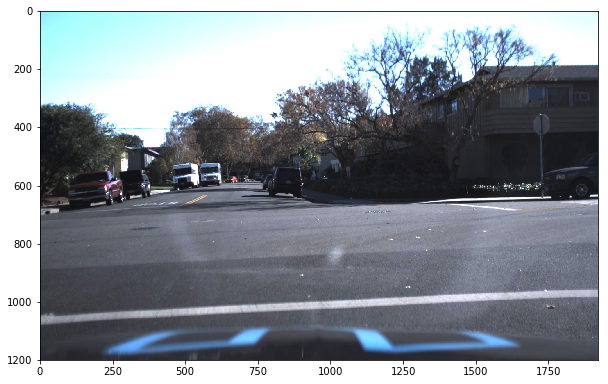

In [6]:
plt.imshow(image)

In [7]:
def draw_each(img, bboxes):
    for bbox in bboxes:
        xmin = int(round(bbox[0] * img.shape[1]))
        ymin = int(round(bbox[1] * img.shape[0]))
        xmax = int(round(bbox[2] * img.shape[1]))
        ymax = int(round(bbox[3] * img.shape[0]))
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax),(0, 255, 0), 6)
    return img

def draw(org_img, org_bboxes, trans_img, trans_bboxes):
    fig = plt.figure(figsize=(30, 25))
    fig_dims = (1, 2)
    ax1 = plt.subplot2grid(fig_dims, (0, 0))
    ax1.set_title('original')
    ax1.imshow(draw_each(org_img, org_bboxes))
    
    ax2 = plt.subplot2grid(fig_dims, (0, 1))
    ax2.set_title('augmented')
    ax2.imshow(draw_each(trans_img, trans_bboxes))
    plt.show()

In [8]:
def denormalize(img, annotations):
    h, w, _ = img.shape
    annotations = np.copy(annotations)
    annotations[:, 0] = annotations[:, 0] * w
    annotations[:, 2] = annotations[:, 2] * w
    annotations[:, 1] = annotations[:, 1] * h
    annotations[:, 3] = annotations[:, 3] * h
    return annotations

def normalize(img, annotations):
    h, w, _ = img.shape
    annotations = np.copy(annotations)
    annotations[:, 0] = annotations[:, 0] / w
    annotations[:, 2] = annotations[:, 2] / w
    annotations[:, 1] = annotations[:, 1] / h
    annotations[:, 3] = annotations[:, 3] / h
    return annotations

## Image Translation

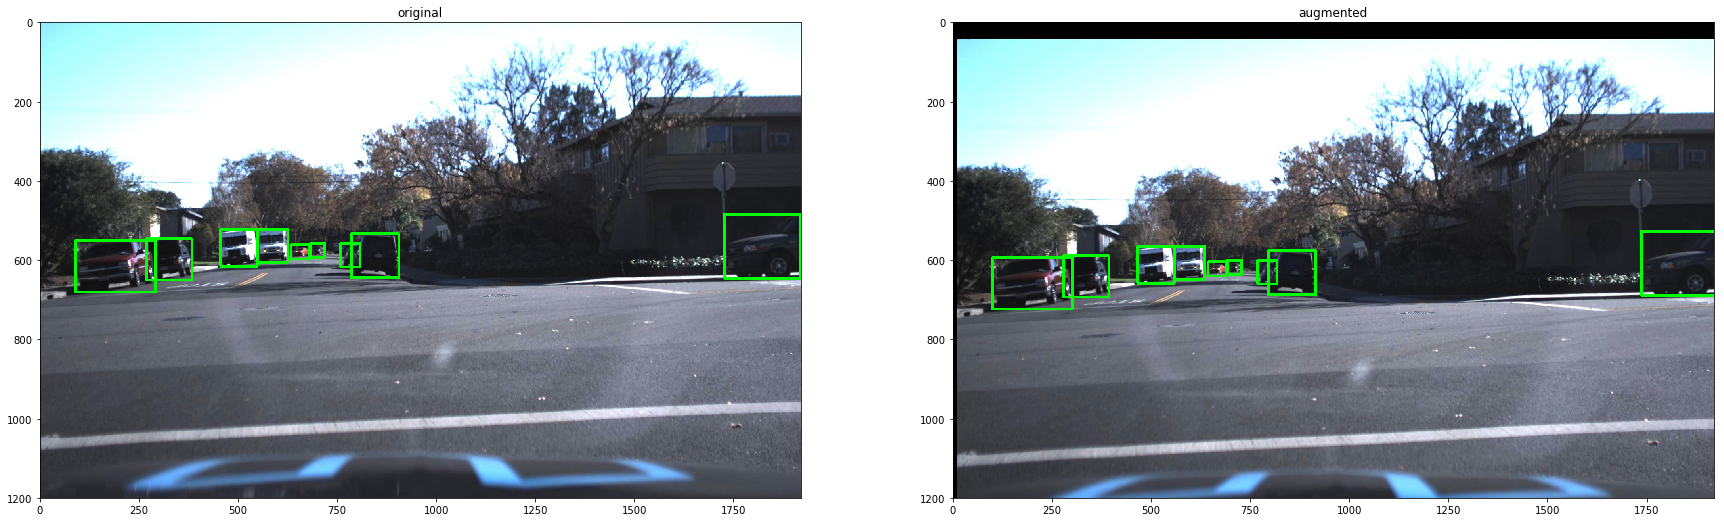

In [9]:
def translate(img, annotations, trans_range=20):
    # Translation augmentation
    annotations = np.copy(annotations)
    h, w, _ = img.shape
    tr_x = trans_range * np.random.uniform() - trans_range/2
    tr_y = trans_range * np.random.uniform() - trans_range/2

    Trans_M = np.float32([[1, 0, tr_x], [0, 1, tr_y]])
    
    annotations[:, 0] = annotations[:, 0] + tr_x # xmin
    annotations[:, 2] = annotations[:, 2] + tr_x # xmax
    annotations[:, 1] = annotations[:, 1] + tr_y # ymin
    annotations[:, 3] = annotations[:, 3] + tr_y # ymax
    
    img_translated = cv2.warpAffine(img, Trans_M, (w, h))

    return img_translated, annotations

image = mpimg.imread('resources/udacity-dataset/object-detection-crowdai/1479498371963069978.jpg')
annotations = gt['object-detection-crowdai/1479498371963069978.jpg']
img_tr, bboxes_tr = translate(image, denormalize(image, annotations), trans_range=200)
bboxes_tr = normalize(img_tr, bboxes_tr)
draw(image, annotations, img_tr, bboxes_tr)

## Image Stretching

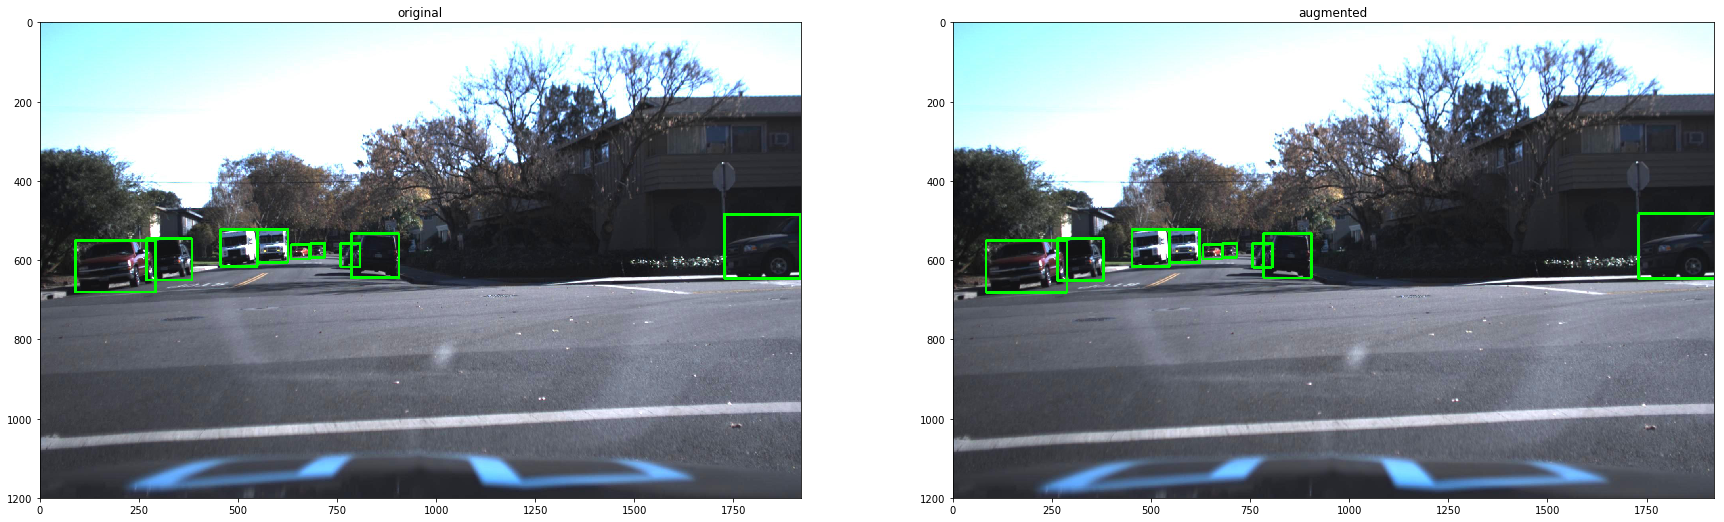

In [10]:
def stretch(img, annotations, scale_range=50):
    # Stretching augmentation 
    annotations = np.copy(annotations)
    tr_x1 = scale_range * np.random.uniform()
    tr_y1 = scale_range * np.random.uniform()
    p1 = (tr_x1, tr_y1)
    tr_x2 = scale_range * np.random.uniform()
    tr_y2 = scale_range * np.random.uniform()
    p2 = (img.shape[1] - tr_x2, tr_y1)

    p3 = (img.shape[1] - tr_x2, img.shape[0] - tr_y2)
    p4 = (tr_x1, img.shape[0] - tr_y2)

    pts1 = np.float32([[p1[0], p1[1]], 
                       [p2[0], p2[1]],
                       [p3[0], p3[1]], 
                       [p4[0], p4[1]]])
    pts2 = np.float32([[0, 0],
                       [img.shape[1], 0], 
                       [img.shape[1], img.shape[0]],
                       [0, img.shape[0]]])

    M = cv2.getPerspectiveTransform(pts1, pts2)
    img = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    img = np.array(img, dtype=np.uint8)
    
    annotations[:, 0] = (annotations[:, 0] - p1[0]) / (p2[0] - p1[0]) * img.shape[1] # xmin
    annotations[:, 2] = (annotations[:, 2] - p1[0]) / (p2[0] - p1[0]) * img.shape[1] # xmax
    annotations[:, 1] = (annotations[:, 1] - p1[1]) / (p3[1] - p1[1]) * img.shape[0] # ymin
    annotations[:, 3] = (annotations[:, 3] - p1[1]) / (p3[1] - p1[1]) * img.shape[0] # ymax
    
    return img, annotations

image = mpimg.imread('resources/udacity-dataset/object-detection-crowdai/1479498371963069978.jpg')
annotations = gt['object-detection-crowdai/1479498371963069978.jpg']
img_scaled, annotations_scaled = stretch(image, denormalize(image, annotations), 10)
annotations_scaled = normalize(img_scaled, annotations_scaled)

draw(image, annotations, img_scaled, annotations_scaled)

## Horizontal Flip

In [1]:
def horizontal_flip(img, bboxes):
    img = img[:, ::-1]
    y[:, [0, 2]] = 1 - y[:, [2, 0]]
    return img, y

image = mpimg.imread('resources/udacity-dataset/object-detection-crowdai/1479498371963069978.jpg')
annotations = gt['object-detection-crowdai/1479498371963069978.jpg']
image_flipped, annotations_flipped = horizontal_flip(image.copy(), annotations.copy())
draw(image, annotations, image_augmented, annotations_augmented)

NameError: name 'mpimg' is not defined

## Combination

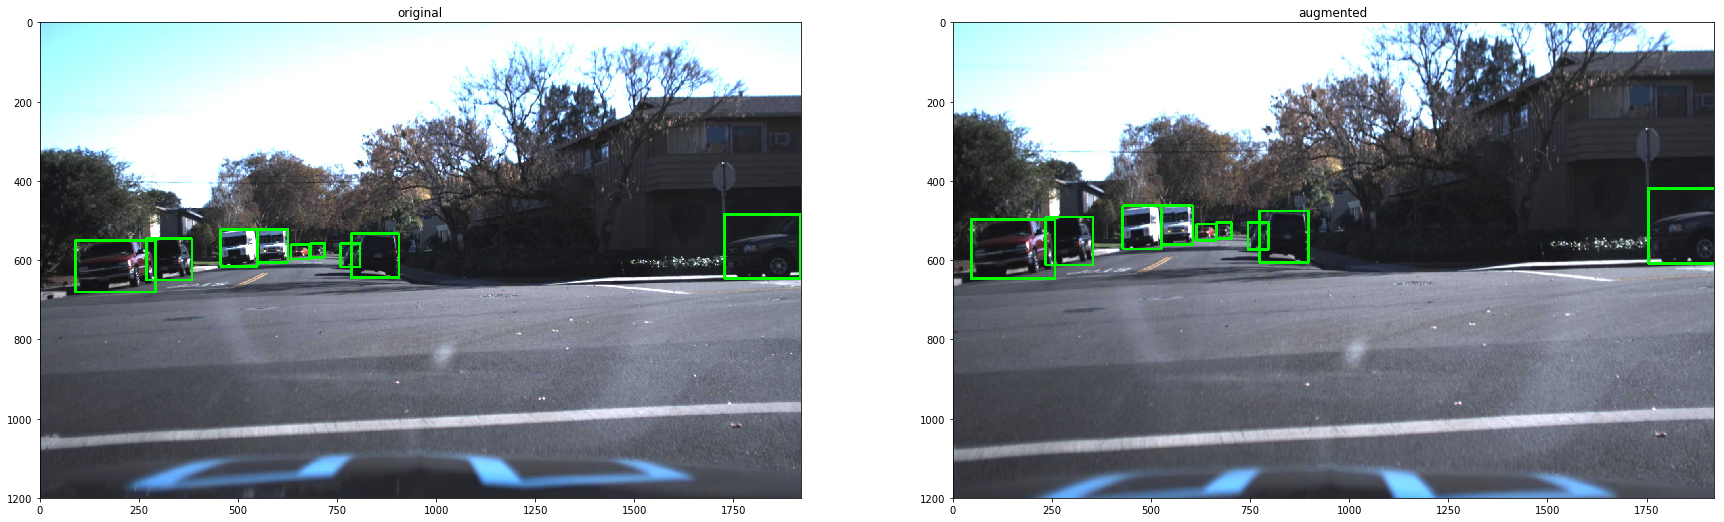

In [12]:
image = mpimg.imread('resources/udacity-dataset/object-detection-crowdai/1479498371963069978.jpg')
annotations = gt['object-detection-crowdai/1479498371963069978.jpg']
image_augmented, annotations_augmented = translate(image, denormalize(image, annotations), trans_range=100)
image_augmented, annotations_augmented = stretch(image_augmented, annotations_augmented, 100)
annotations_augmented = normalize(image_augmented, annotations_augmented)

draw(image, annotations, image_augmented, annotations_augmented)